In [1]:
!pip install scikit-learn datasets transformers

In [2]:
from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [3]:
import os
import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔁 Avaliação no conjunto de teste
predictions, true_label_ids, _ = trainer.predict(dataset_dict["test"])
predicted_label_ids = np.argmax(predictions, axis=2)

# 🔁 Reconstruir predições e rótulos com B-/I-
true_labels_bio = []
pred_labels_bio = []

for true_ids, pred_ids in zip(true_label_ids, predicted_label_ids):
    true_seq = []
    pred_seq = []
    for true_id, pred_id in zip(true_ids, pred_ids):
        if true_id != -100:
            true_seq.append(id2label[true_id])
            pred_seq.append(id2label[pred_id])
    true_labels_bio.append(true_seq)
    pred_labels_bio.append(pred_seq)

# 🔁 Versão SEM B-/I-
def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]

true_labels_plain = strip_bio_prefix(true_labels_bio)
pred_labels_plain = strip_bio_prefix(pred_labels_bio)

# 🔁 Flatten e remover "O"
flat_true_bio = [tag for seq in true_labels_bio for tag in seq if tag != "O"]
flat_pred_bio = [tag for seq in pred_labels_bio for tag in seq if tag != "O"]

flat_true_plain = [tag for seq in true_labels_plain for tag in seq if tag != "O"]
flat_pred_plain = [tag for seq in pred_labels_plain for tag in seq if tag != "O"]

labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))

# 🔁 Avaliação
print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio, flat_pred_bio, labels=labels_bio)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain, flat_pred_plain, labels=labels_plain)
print(report_plain)

# 🔁 Matriz de Confusão (COM prefixos)
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BERT (com B-/I-)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_bert_com_prefixos.png"))
plt.show()

# 🔁 Matriz de Confusão (SEM prefixos)
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BERT (sem B-/I-)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_bert_sem_prefixos.png"))
plt.show()

# === SALVAR NO GOOGLE DRIVE ===
GDRIVE_EVAL_DIR = os.path.join(GDRIVE_PATH, "avaliacao_bert")
os.makedirs(GDRIVE_EVAL_DIR, exist_ok=True)

def salvar_json(obj, nome_arquivo):
    with open(os.path.join(GDRIVE_EVAL_DIR, nome_arquivo), "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# 📝 Salvar predições e rótulos
salvar_json(true_labels_bio, "true_labels_bio.json")
salvar_json(pred_labels_bio, "pred_labels_bio.json")
salvar_json(true_labels_plain, "true_labels_plain.json")
salvar_json(pred_labels_plain, "pred_labels_plain.json")

# 🧠 Salvar mapeamentos
salvar_json(label2id, "label2id.json")
salvar_json(id2label, "id2label.json")

# 📄 Salvar relatórios como texto
with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_bio.txt"), "w", encoding="utf-8") as f:
    f.write(report_bio)

with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_plain.txt"), "w", encoding="utf-8") as f:
    f.write(report_plain)

print(f"\n✅ Resultados salvos em: {GDRIVE_EVAL_DIR}")


NameError: name 'trainer' is not defined

In [4]:
import sys
print(sys.version)

3.12.11 (main, Jun  4 2025, 08:56:18) [GCC 11.4.0]


In [ ]:
import os
GDRIVE_PATH:str = '/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados'
DATASET_PRIMEIRO_HAREM = os.path.join(GDRIVE_PATH, 'dataset','output_chatgpt.json')

import json
import numpy as np
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer, TrainingArguments, pipeline, DataCollatorForTokenClassification
from datasets import DatasetDict, Dataset
from sklearn.metrics import classification_report
import torch

# Configuração
MODEL_NAME = "neuralmind/bert-base-portuguese-cased"
DATA_PATH = DATASET_PRIMEIRO_HAREM  # Atualize com o caminho correto
OUTPUT_DIR = "./ner_model"

# Carregar Dataset
def load_dataset(data_path):
    with open(data_path, encoding="utf-8") as f:
        data = json.load(f)

    dataset = []
    for doc in data:
        text = doc["doc_text"]

        # Inicializa todos os caracteres como "O"
        char_labels = ["O"] * len(text)

        # Marca as entidades no texto
        for entity in doc["entities"]:
            start = entity["start_offset"]
            end = entity["end_offset"]
            label = entity["label"]

            # Marca o primeiro caractere como B- e os restantes como I-
            char_labels[start] = f"B-{label}"
            for i in range(start + 1, end):
                char_labels[i] = f"I-{label}"

        dataset.append({
            "id": doc.get("doc_id", ""),
            "text": text,
            "char_labels": char_labels
        })

    return dataset

# Definir lista de labels
def get_label_list(dataset):
    unique_labels = set()
    for example in dataset:
        unique_labels.update(example["char_labels"])

    # Ordena as labels para garantir consistência
    label_list = sorted(list(unique_labels))
    return label_list

# Carregar dados
dataset = load_dataset(DATA_PATH)
label_list = get_label_list(dataset)

# Criar mapeamento de labels para IDs
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Tokenização e preparação dos dados
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_and_align_labels(examples):
    tokenized_inputs = {
        "input_ids": [],
        "attention_mask": [],
        "labels": []
    }

    for example in examples:
        text = example["text"]
        char_labels = example["char_labels"]

        # Tokenizar o texto
        encoded = tokenizer(
            text,
            padding="max_length",
            truncation=True,
            max_length=512,
            return_offsets_mapping=True
        )

        # Alinhar as labels com os tokens
        labels = []
        offset_mapping = encoded["offset_mapping"]

        for i, offset in enumerate(offset_mapping):
            if offset[0] == offset[1]:  # Token especial ([CLS], [SEP], [PAD])
                labels.append(-100)
            else:
                # Pegar a label do primeiro caractere do token
                if offset[0] < len(char_labels):
                    labels.append(label2id.get(char_labels[offset[0]], label2id["O"]))
                else:
                    labels.append(label2id["O"])

        tokenized_inputs["input_ids"].append(encoded["input_ids"])
        tokenized_inputs["attention_mask"].append(encoded["attention_mask"])
        tokenized_inputs["labels"].append(labels)

    return tokenized_inputs

# Dividir o dataset em treinamento, validação e teste (80% / 10% / 10%)
train_size = int(0.8 * len(dataset))
temp_test_size = len(dataset) - train_size
val_size = int(temp_test_size / 2)
test_size = temp_test_size - val_size

train_examples = dataset[:train_size]
val_examples = dataset[train_size:train_size+val_size]
test_examples = dataset[train_size+val_size:]

print(f"Tamanho do conjunto de treinamento: {len(train_examples)}")
print(f"Tamanho do conjunto de validação: {len(val_examples)}")
print(f"Tamanho do conjunto de teste: {len(test_examples)}")

# Preparar os datasets
train_tokenized = tokenize_and_align_labels(train_examples)
val_tokenized = tokenize_and_align_labels(val_examples)
test_tokenized = tokenize_and_align_labels(test_examples)

train_dataset = Dataset.from_dict(train_tokenized)
val_dataset = Dataset.from_dict(val_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})


# Criar data collator para lidar com o padding
data_collator = DataCollatorForTokenClassification(
    tokenizer=tokenizer,
    padding=True,
    max_length=512,
    return_tensors="pt"
)

# Criar e treinar o modelo
model = AutoModelForTokenClassification.from_pretrained(
    MODEL_NAME,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.train()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/43.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/647 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/210k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Tamanho do conjunto de treinamento: 36325
Tamanho do conjunto de validação: 4541
Tamanho do conjunto de teste: 4541


pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at neuralmind/bert-base-portuguese-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-4-949b5892931c>:166: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(


model.safetensors:   0%|          | 0.00/438M [00:00<?, ?B/s]

Epoch,Training Loss,Validation Loss
1,0.093900,0.096013
2,0.077200,0.089561
3,0.062800,0.089529


/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:2718: UserWarning: `max_length` is ignored when `padding`=`True` and there is no truncation strategy. To pad to max length, use `padding='max_length'`.
  warnings.warn(
/usr

TrainOutput(global_step=13623, training_loss=0.08473255164751194, metrics={'train_runtime': 12131.2612, 'train_samples_per_second': 8.983, 'train_steps_per_second': 1.123, 'total_flos': 2.84802202854144e+16, 'train_loss': 0.08473255164751194, 'epoch': 3.0})

In [ ]:
# Após trainer.train()
OUTPUT_DIR = "/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model"

model.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)


('/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model/tokenizer_config.json',
 '/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model/special_tokens_map.json',
 '/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model/vocab.txt',
 '/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model/added_tokens.json',
 '/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/ner_model/tokenizer.json')

=== RELATÓRIO COM PREFIXOS B-/I- ===


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     B-BANCO       0.84      0.48      0.61      1026
       B-CNH       0.91      0.80      0.85       279
      B-CNPJ       0.94      0.92      0.93       124
       B-CPF       0.94      0.88      0.91       792
     B-EMAIL       0.93      0.69      0.79       100
   B-EMPRESA       0.90      0.58      0.70      1737
  B-ENDEREÇO       0.97      0.66      0.78      3078
    B-PESSOA       0.95      0.81      0.87     10504
        B-RG       0.96      0.87      0.91       457
  B-TELEFONE       0.89      0.67      0.76      1024
   B-VEÍCULO       0.96      0.59      0.73      5032
     I-BANCO       0.96      0.59      0.73      3976
       I-CNH       0.99      0.78      0.87       848
      I-CNPJ       0.99      0.96      0.98      1168
       I-CPF       0.99      0.89      0.94      4076
     I-EMAIL       1.00      0.86      0.92       983
   I-EMPRESA       0.95      0.69      0.80      9162
  I-ENDEREÇO       0.98    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

       BANCO       0.98      0.59      0.74      5002
         CNH       0.99      0.80      0.89      1127
        CNPJ       1.00      0.96      0.98      1292
         CPF       1.00      0.90      0.95      4868
       EMAIL       1.00      0.85      0.92      1083
     EMPRESA       0.96      0.68      0.80     10899
    ENDEREÇO       0.99      0.69      0.82     15502
           O       0.00      0.00      0.00         0
      PESSOA       1.00      0.93      0.96     68112
          RG       0.99      0.82      0.90      1851
    TELEFONE       0.99      0.89      0.94      6724
     VEÍCULO       1.00      0.68      0.81     37019

    accuracy                           0.81    153479
   macro avg       0.91      0.73      0.81    153479
weighted avg       0.99      0.81      0.89    153479



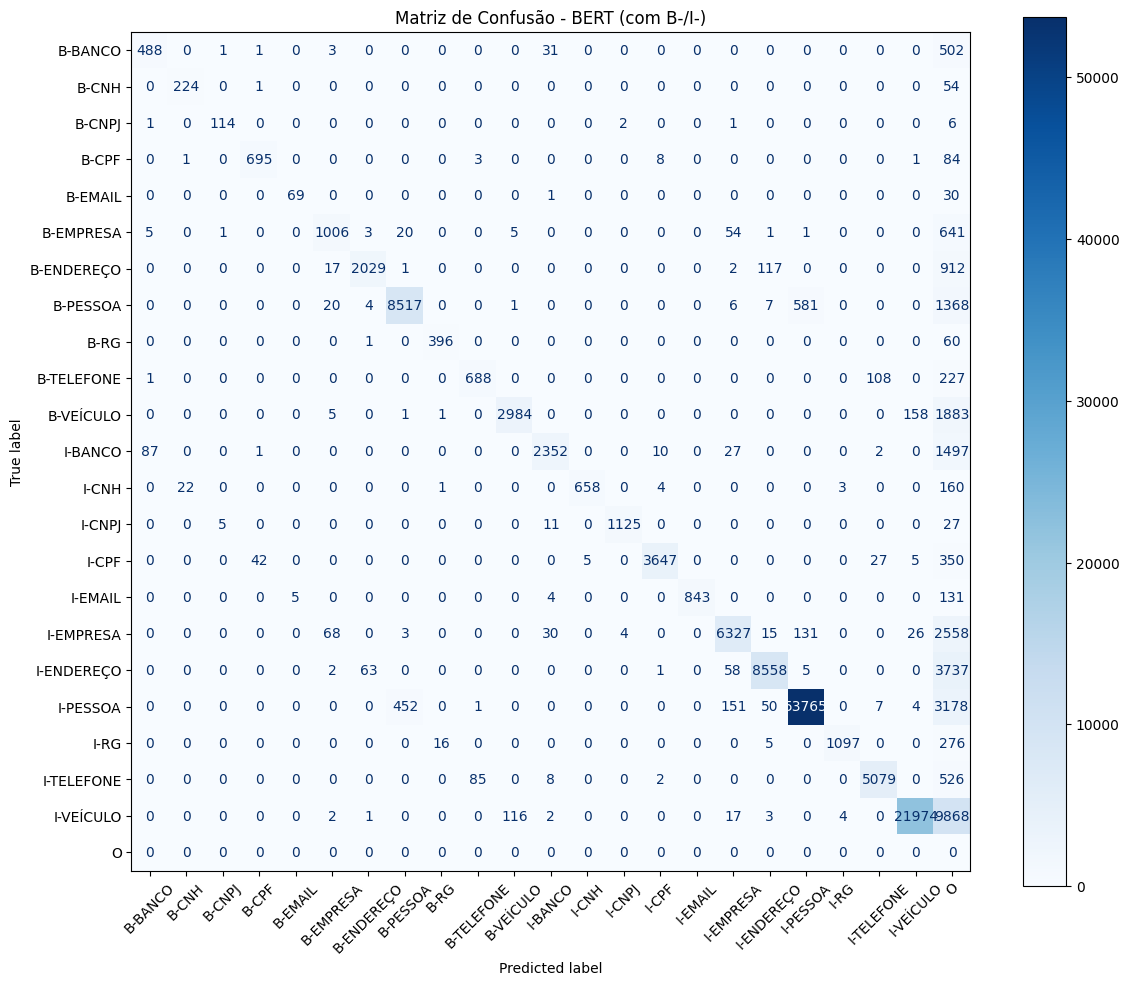

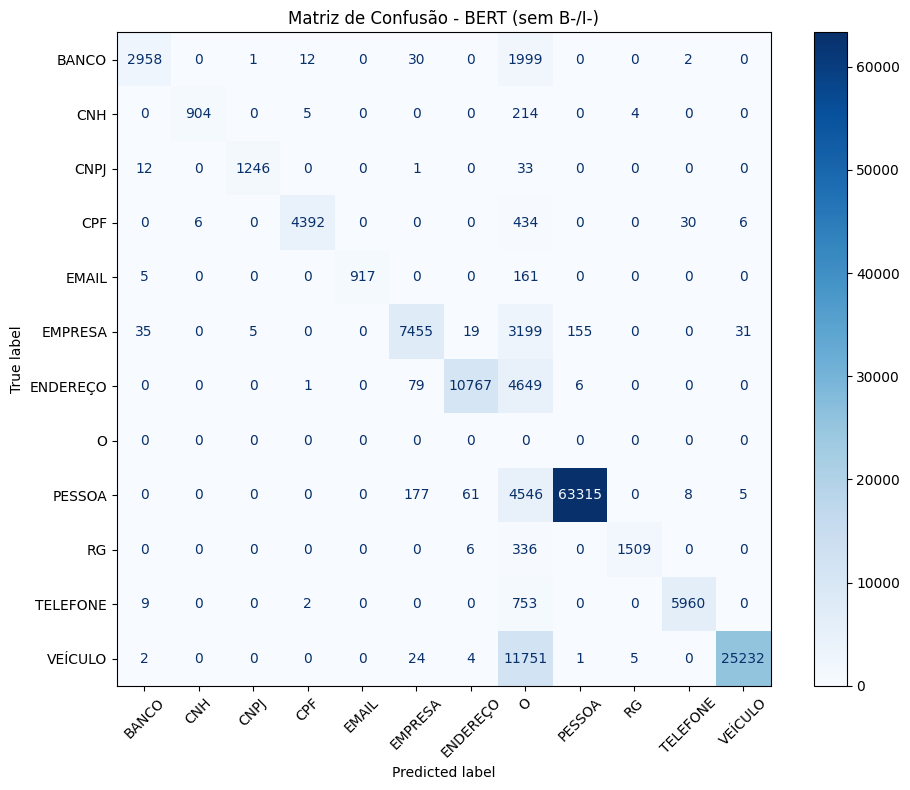


✅ Resultados salvos em: /content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/avaliacao_bert


In [ ]:
import os
import json
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 🔁 Avaliação no conjunto de teste
predictions, true_label_ids, _ = trainer.predict(dataset_dict["test"])
predicted_label_ids = np.argmax(predictions, axis=2)


# 🔁 Reconstruir predições e rótulos com B-/I-
true_labels_bio = []
pred_labels_bio = []

for true_ids, pred_ids in zip(true_label_ids, predicted_label_ids):
    true_seq = []
    pred_seq = []
    for t_id, p_id in zip(true_ids, pred_ids):
        if t_id != -100:
            true_seq.append(id2label.get(t_id, "O"))
            pred_seq.append(id2label.get(p_id, "O"))
    min_len = min(len(true_seq), len(pred_seq))
    true_labels_bio.append(true_seq[:min_len])
    pred_labels_bio.append(pred_seq[:min_len])

# 🔁 Versão SEM B-/I-
def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]

true_labels_plain = strip_bio_prefix(true_labels_bio)
pred_labels_plain = strip_bio_prefix(pred_labels_bio)

# 🔁 Flatten e alinhar com remoção de "O"
flat_true_bio = []
flat_pred_bio = []
for t_seq, p_seq in zip(true_labels_bio, pred_labels_bio):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_bio.append(t)
            flat_pred_bio.append(p)

flat_true_plain = []
flat_pred_plain = []
for t_seq, p_seq in zip(true_labels_plain, pred_labels_plain):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_plain.append(t)
            flat_pred_plain.append(p)

# 🔁 Labels únicos
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))

# 🔁 Avaliação
print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio, flat_pred_bio, labels=labels_bio)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain, flat_pred_plain, labels=labels_plain)
print(report_plain)

# 🔁 Matriz de Confusão (COM prefixos)
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(12, 10))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BERT (com B-/I-)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_bert_com_prefixos.png"))
plt.show()

# 🔁 Matriz de Confusão (SEM prefixos)
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BERT (sem B-/I-)")
plt.tight_layout()
plt.savefig(os.path.join(OUTPUT_DIR, "confusion_matrix_bert_sem_prefixos.png"))
plt.show()

# === SALVAR NO GOOGLE DRIVE ===
GDRIVE_EVAL_DIR = os.path.join(GDRIVE_PATH, "avaliacao_bert")
os.makedirs(GDRIVE_EVAL_DIR, exist_ok=True)

def salvar_json(obj, nome_arquivo):
    with open(os.path.join(GDRIVE_EVAL_DIR, nome_arquivo), "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

# 📝 Salvar predições e rótulos
salvar_json(true_labels_bio, "true_labels_bio.json")
salvar_json(pred_labels_bio, "pred_labels_bio.json")
salvar_json(true_labels_plain, "true_labels_plain.json")
salvar_json(pred_labels_plain, "pred_labels_plain.json")

# 🧠 Salvar mapeamentos
salvar_json(label2id, "label2id.json")
salvar_json(id2label, "id2label.json")

# 📄 Salvar relatórios como texto
with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_bio.txt"), "w", encoding="utf-8") as f:
    f.write(report_bio)

with open(os.path.join(GDRIVE_EVAL_DIR, "classification_report_plain.txt"), "w", encoding="utf-8") as f:
    f.write(report_plain)

print(f"\n✅ Resultados salvos em: {GDRIVE_EVAL_DIR}")


=== RELATÓRIO COM PREFIXOS B-/I- ===
              precision    recall  f1-score   support

     B-BANCO       0.68      0.48      0.56      1026
       B-CNH       0.77      0.80      0.79       279
      B-CNPJ       0.80      0.92      0.85       124
       B-CPF       0.83      0.88      0.85       792
     B-EMAIL       0.82      0.69      0.75       100
   B-EMPRESA       0.72      0.58      0.64      1737
  B-ENDEREÇO       0.69      0.66      0.68      3078
    B-PESSOA       0.81      0.81      0.81     10504
        B-RG       0.85      0.87      0.86       457
  B-TELEFONE       0.66      0.67      0.67      1024
   B-VEÍCULO       0.64      0.59      0.62      5032
     I-BANCO       0.75      0.59      0.66      3976
       I-CNH       0.73      0.78      0.75       848
      I-CNPJ       0.78      0.96      0.86      1168
       I-CPF       0.81      0.89      0.85      4076
     I-EMAIL       0.91      0.86      0.88       983
   I-EMPRESA       0.76      0.69      0.73 

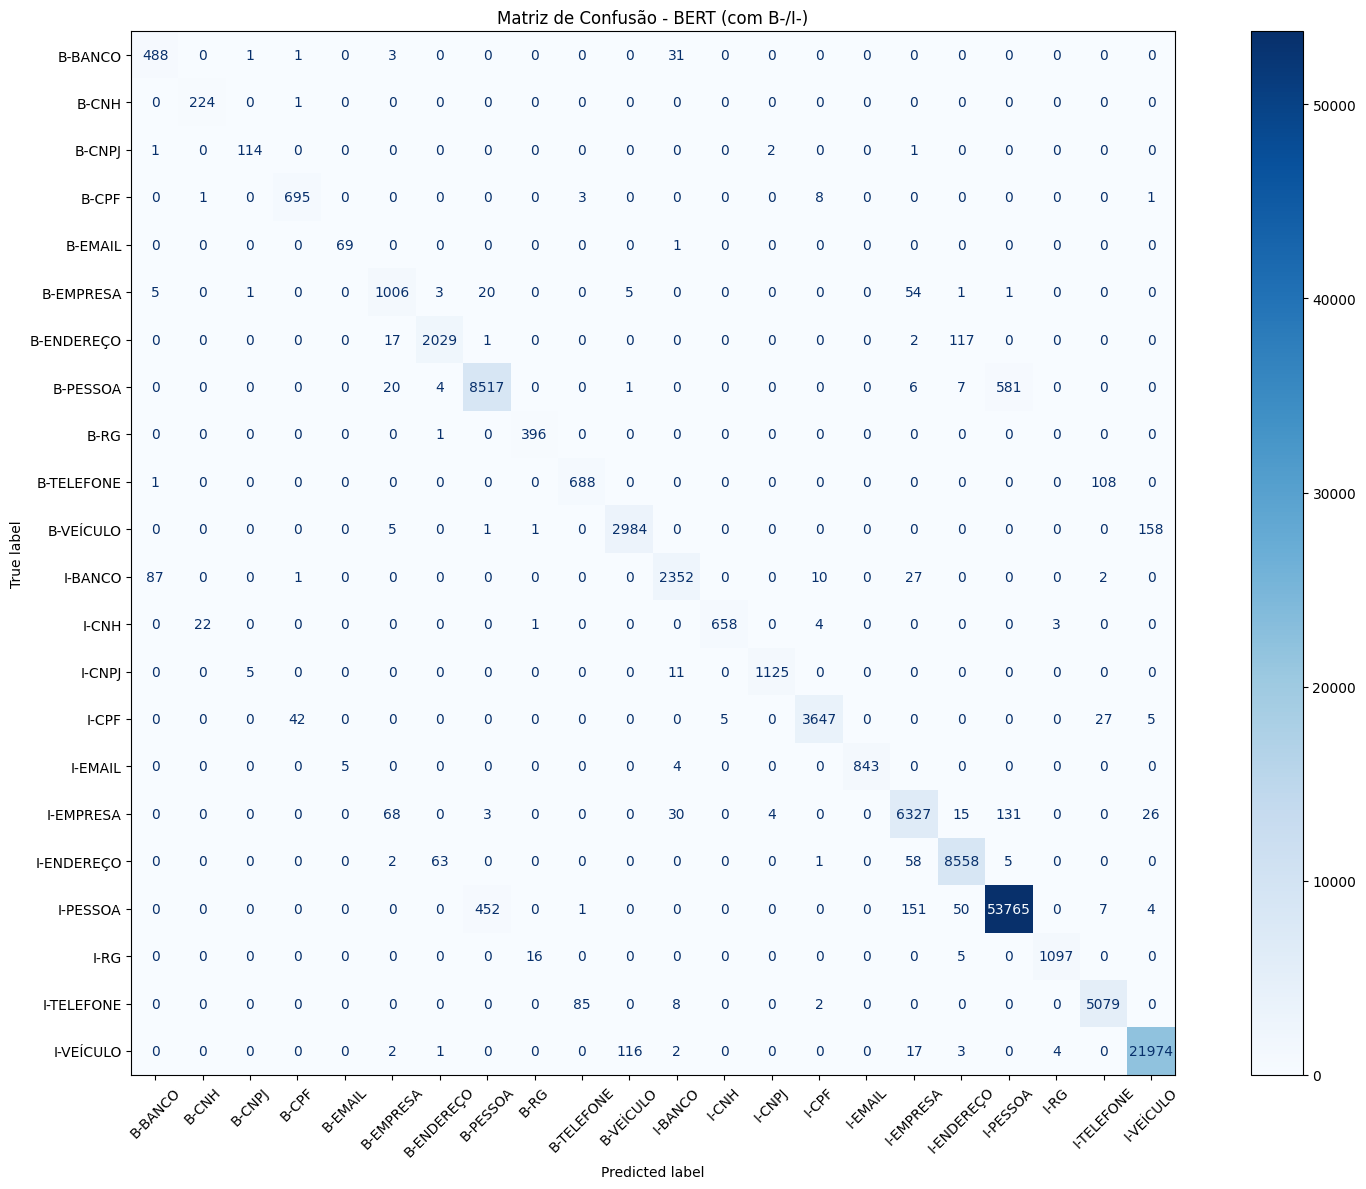

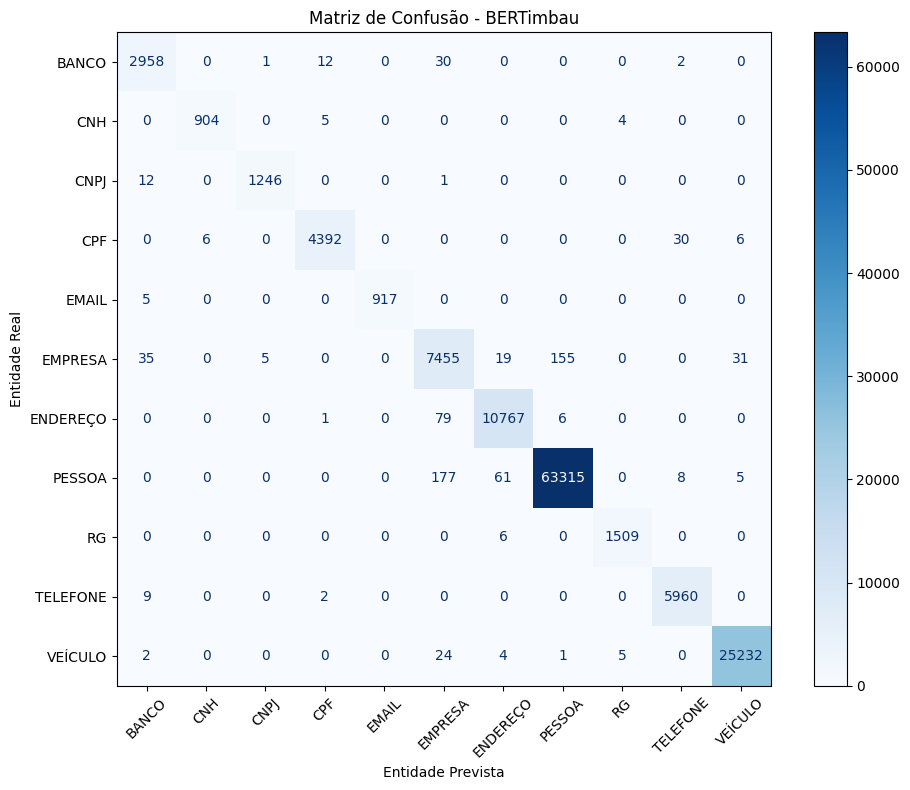

In [6]:
import os
import json
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Caminho para os resultados salvos no Google Drive
GDRIVE_EVAL_DIR = "/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados/avaliacao_bert"

# Função para carregar JSON
def carregar_json(nome_arquivo):
    caminho = os.path.join(GDRIVE_EVAL_DIR, nome_arquivo)
    with open(caminho, "r", encoding="utf-8") as f:
        return json.load(f)

# Carregar arquivos
true_labels_bio = carregar_json("true_labels_bio.json")
pred_labels_bio = carregar_json("pred_labels_bio.json")
true_labels_plain = carregar_json("true_labels_plain.json")
pred_labels_plain = carregar_json("pred_labels_plain.json")

# Flatten geral (para report)
flat_true_bio_all = [tag for seq in true_labels_bio for tag in seq]
flat_pred_bio_all = [tag for seq in pred_labels_bio for tag in seq]
flat_true_plain_all = [tag for seq in true_labels_plain for tag in seq]
flat_pred_plain_all = [tag for seq in pred_labels_plain for tag in seq]

# Flatten sem 'O' (para matriz)
flat_true_bio = []
flat_pred_bio = []
for t_seq, p_seq in zip(true_labels_bio, pred_labels_bio):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_bio.append(t)
            flat_pred_bio.append(p)

flat_true_plain = []
flat_pred_plain = []
for t_seq, p_seq in zip(true_labels_plain, pred_labels_plain):
    for t, p in zip(t_seq, p_seq):
        if t != "O":
            flat_true_plain.append(t)
            flat_pred_plain.append(p)



# Labels
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio) - {"O"})) #sem o 'O'
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain) - {"O"})) #sem o 'O'

# labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))
# labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))
labels_bio_all = sorted(list(set(flat_true_bio_all + flat_pred_bio_all)))
labels_plain_all = sorted(list(set(flat_true_plain_all + flat_pred_plain_all)))

# Avaliação

all_non_o_bio   = sorted(list(set(flat_true_bio   + flat_pred_bio)))
all_non_o_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))





print("=== RELATÓRIO COM PREFIXOS B-/I- ===")
report_bio = classification_report(flat_true_bio_all, flat_pred_bio_all, labels=labels_bio_all)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- ===")
report_plain = classification_report(flat_true_plain_all, flat_pred_plain_all, labels=labels_plain_all)
print(report_plain)

print("=== RELATÓRIO COM PREFIXOS B-/I- (sem 'O') ===")
report_bio = classification_report(flat_true_bio, flat_pred_bio,
                                   labels=all_non_o_bio, zero_division=0)
print(report_bio)

print("\n=== RELATÓRIO SEM PREFIXOS B-/I- (sem 'O') ===")
report_plain = classification_report(flat_true_plain, flat_pred_plain,
                                     labels=all_non_o_plain, zero_division=0)

print(report_plain)

# Matriz de confusão - com prefixos (exclui O)
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
fig, ax = plt.subplots(figsize=(16, 12))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", ax=ax, xticks_rotation=45)
plt.title("Matriz de Confusão - BERT (com B-/I-)")
plt.tight_layout()
plt.savefig("confusion_matrix_bert_bio_recuperado.eps", format="eps")
plt.show()

# Matriz de confusão - sem prefixos (exclui O)
cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
fig, ax = plt.subplots(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", ax=ax, xticks_rotation=45)

ax.set_xlabel("Entidade Prevista")
ax.set_ylabel("Entidade Real")
plt.title("Matriz de Confusão - BERTimbau")
plt.tight_layout()
plt.savefig("confusion_matrix_bert_plain_recuperado.eps", format="eps")
plt.show()


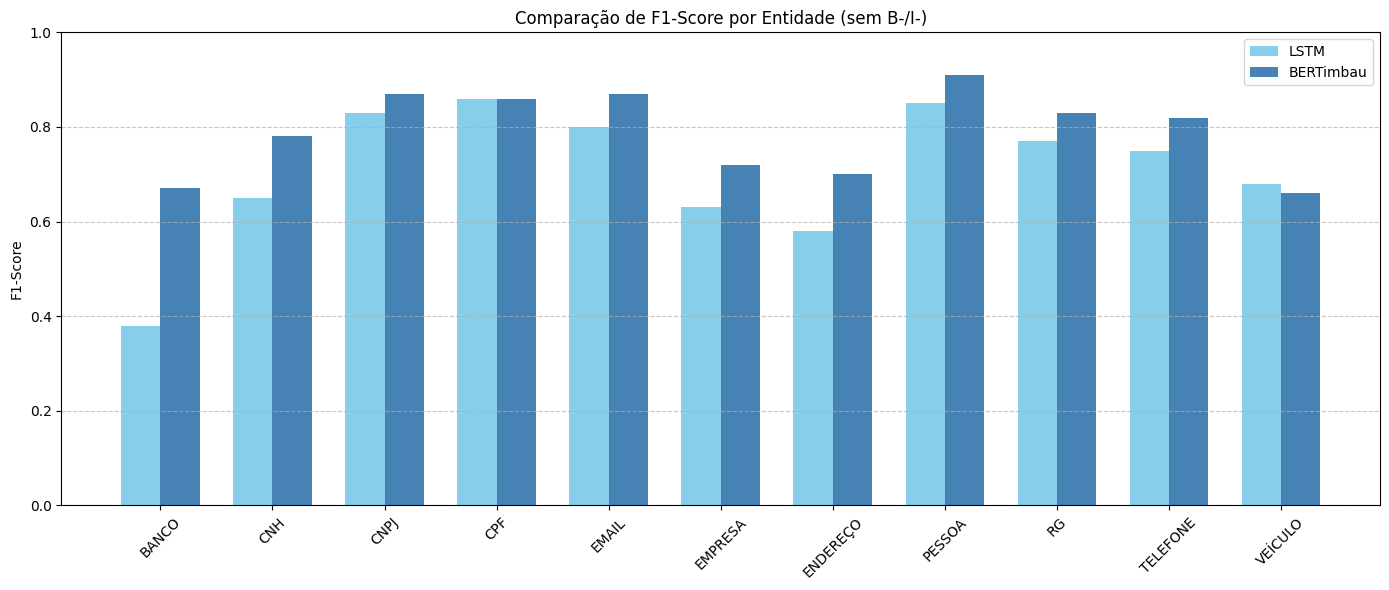

In [ ]:
# Remover DEPOENTE da análise
filtered_entities = [
    "BANCO", "CNH", "CNPJ", "CPF", "EMAIL", "EMPRESA",
    "ENDEREÇO", "PESSOA", "RG", "TELEFONE", "VEÍCULO"
]

# F1-Scores correspondentes sem DEPOENTE
f1_lstm_filtered = [0.38, 0.65, 0.83, 0.86, 0.80, 0.63, 0.58, 0.85, 0.77, 0.75, 0.68]
f1_bert_filtered = [0.67, 0.78, 0.87, 0.86, 0.87, 0.72, 0.70, 0.91, 0.83, 0.82, 0.66]

x = np.arange(len(filtered_entities))
width = 0.35

fig, ax = plt.subplots(figsize=(14, 6))
bar1 = ax.bar(x - width/2, f1_lstm_filtered, width, label='LSTM', color='skyblue')
bar2 = ax.bar(x + width/2, f1_bert_filtered, width, label='BERTimbau', color='steelblue')

ax.set_ylabel('F1-Score')
ax.set_title('Comparação de F1-Score por Entidade (sem B-/I-)')
ax.set_xticks(x)
ax.set_xticklabels(filtered_entities, rotation=45)
ax.set_ylim(0, 1)
ax.legend()
ax.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


# do zero


In [ ]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertConfig, BertForTokenClassification, AutoTokenizer, Trainer, TrainingArguments, DataCollatorForTokenClassification
from datasets import DatasetDict, Dataset
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

# Caminho no Google Drive
GDRIVE_PATH = "/content/drive/MyDrive/AKCIT - NLP (Desidentificação e identificação de dados sensíveis)/modelos-selecionados"
DATA_PATH = os.path.join(GDRIVE_PATH, "dataset", "output_chatgpt.json")
OUTPUT_DIR = "./ner_model_zero"

# Carregar Dataset
def load_dataset(data_path):
    with open(data_path, encoding="utf-8") as f:
        data = json.load(f)
    dataset = []
    for doc in data:
        text = doc["doc_text"]
        char_labels = ["O"] * len(text)
        for entity in doc["entities"]:
            start, end, label = entity["start_offset"], entity["end_offset"], entity["label"]
            char_labels[start] = f"B-{label}"
            for i in range(start + 1, end):
                char_labels[i] = f"I-{label}"
        dataset.append({"id": doc.get("doc_id", ""), "text": text, "char_labels": char_labels})
    return dataset

# Funções auxiliares
def get_label_list(dataset):
    unique_labels = set()
    for example in dataset:
        unique_labels.update(example["char_labels"])
    return sorted(list(unique_labels))

def tokenize_and_align_labels(examples):
    tokenized_inputs = {"input_ids": [], "attention_mask": [], "labels": []}
    for example in examples:
        text = example["text"]
        char_labels = example["char_labels"]
        encoded = tokenizer(text, padding="max_length", truncation=True, max_length=512, return_offsets_mapping=True)
        labels = []
        for offset in encoded["offset_mapping"]:
            if offset[0] == offset[1]:
                labels.append(-100)
            elif offset[0] < len(char_labels):
                labels.append(label2id.get(char_labels[offset[0]], label2id["O"]))
            else:
                labels.append(label2id["O"])
        tokenized_inputs["input_ids"].append(encoded["input_ids"])
        tokenized_inputs["attention_mask"].append(encoded["attention_mask"])
        tokenized_inputs["labels"].append(labels)
    return tokenized_inputs

def strip_bio_prefix(tags_nested):
    return [[tag.replace("B-", "").replace("I-", "") for tag in sentence] for sentence in tags_nested]

# Preparar dados
dataset = load_dataset(DATA_PATH)
label_list = get_label_list(dataset)
label2id = {label: i for i, label in enumerate(label_list)}
id2label = {i: label for i, label in enumerate(label_list)}

# Tokenizer e vocabulário
tokenizer = AutoTokenizer.from_pretrained("neuralmind/bert-base-portuguese-cased")
vocab_size = tokenizer.vocab_size

# Divisão do dataset
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
train_examples = dataset[:train_size]
val_examples = dataset[train_size:train_size+val_size]
test_examples = dataset[train_size+val_size:]

train_tokenized = tokenize_and_align_labels(train_examples)
val_tokenized = tokenize_and_align_labels(val_examples)
test_tokenized = tokenize_and_align_labels(test_examples)

train_dataset = Dataset.from_dict(train_tokenized)
val_dataset = Dataset.from_dict(val_tokenized)
test_dataset = Dataset.from_dict(test_tokenized)

dataset_dict = DatasetDict({
    "train": train_dataset,
    "validation": val_dataset,
    "test": test_dataset
})

# Criar modelo do zero
config = BertConfig(
    vocab_size=vocab_size,
    hidden_size=768,
    num_hidden_layers=12,
    num_attention_heads=12,
    intermediate_size=3072,
    max_position_embeddings=512,
    type_vocab_size=2,
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id
)

model = BertForTokenClassification(config)

data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer, padding=True, max_length=512, return_tensors="pt")

training_args = TrainingArguments(
    output_dir=OUTPUT_DIR,
    evaluation_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    report_to="none"
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_dict["train"],
    eval_dataset=dataset_dict["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer
)

trainer.train()

# Avaliação
predictions, true_label_ids, _ = trainer.predict(dataset_dict["test"])
predicted_label_ids = np.argmax(predictions, axis=2)

true_labels_bio = []
pred_labels_bio = []
for true_ids, pred_ids in zip(true_label_ids, predicted_label_ids):
    true_seq = []
    pred_seq = []
    for true_id, pred_id in zip(true_ids, pred_ids):
        if true_id != -100:
            true_seq.append(id2label[true_id])
            pred_seq.append(id2label[pred_id])
    true_labels_bio.append(true_seq)
    pred_labels_bio.append(pred_seq)

# Avaliar
flat_true_bio = [tag for seq in true_labels_bio for tag in seq if tag != "O"]
flat_pred_bio = [tag for seq in pred_labels_bio for tag in seq if tag != "O"]
labels_bio = sorted(list(set(flat_true_bio + flat_pred_bio)))

flat_true_plain = [tag for seq in strip_bio_prefix(true_labels_bio) for tag in seq if tag != "O"]
flat_pred_plain = [tag for seq in strip_bio_prefix(pred_labels_bio) for tag in seq if tag != "O"]
labels_plain = sorted(list(set(flat_true_plain + flat_pred_plain)))

# Relatórios
report_bio = classification_report(flat_true_bio, flat_pred_bio, labels=labels_bio)
report_plain = classification_report(flat_true_plain, flat_pred_plain, labels=labels_plain)
print("=== COM PREFIXOS B-/I- ===\n", report_bio)
print("=== SEM PREFIXOS ===\n", report_plain)

# Matrizes de confusão
cm_bio = confusion_matrix(flat_true_bio, flat_pred_bio, labels=labels_bio)
plt.figure(figsize=(12, 10))
ConfusionMatrixDisplay(cm_bio, display_labels=labels_bio).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusão BERT (com B-/I-)")
plt.savefig("confusion_matrix_bert_zero_bio.png")
plt.show()

cm_plain = confusion_matrix(flat_true_plain, flat_pred_plain, labels=labels_plain)
plt.figure(figsize=(10, 8))
ConfusionMatrixDisplay(cm_plain, display_labels=labels_plain).plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusão BERT (sem B-/I-)")
plt.savefig("confusion_matrix_bert_zero_plain.png")
plt.show()

# Salvar no Google Drive
EVAL_DIR = os.path.join(GDRIVE_PATH, "avaliacao_bert_zero")
os.makedirs(EVAL_DIR, exist_ok=True)

def salvar_json(obj, nome):
    with open(os.path.join(EVAL_DIR, nome), "w", encoding="utf-8") as f:
        json.dump(obj, f, ensure_ascii=False, indent=2)

salvar_json(true_labels_bio, "true_labels_bio.json")
salvar_json(pred_labels_bio, "pred_labels_bio.json")
salvar_json(strip_bio_prefix(true_labels_bio), "true_labels_plain.json")
salvar_json(strip_bio_prefix(pred_labels_bio), "pred_labels_plain.json")
salvar_json(label2id, "label2id.json")
salvar_json(id2label, "id2label.json")

with open(os.path.join(EVAL_DIR, "classification_report_bio.txt"), "w", encoding="utf-8") as f:
    f.write(report_bio)

with open(os.path.join(EVAL_DIR, "classification_report_plain.txt"), "w", encoding="utf-8") as f:
    f.write(report_plain)

print(f"\n✅ Resultados salvos em: {EVAL_DIR}")
